## Model explainability
Explainability is the extent to which a model can be explained in human terms. Interpretability is the extent to which you can explain the outcome of a model after a change in input parameters. Often times we are working with black box models, which only show the prediction and not the steps that led up to that decision. Explainability methods uncover vulnerabilities in models and are able to offer a broader insight as to how differing inputs change the outcome. 

We'll start by loading the data and splitting the data into training and test sets.

In [1]:
import pandas as pd
import sklearn

pt_info_clean = pd.read_csv("../data/processed/pt_info_clean.csv")

In [2]:
from sklearn import model_selection
train, test = model_selection.train_test_split(pt_info_clean, random_state=43)

We'll translate the pandas data frame into numpy arrays in order to agree with the necessary inputs for our explainability methods.

In [3]:
import numpy as np
x_train = np.asarray(train.iloc[:,2:train.shape[1]])
x_test = np.asarray(test.iloc[:,2:train.shape[1]])
y_train = np.asarray(train['mrsa_positive'])
y_test = np.asarray(test['mrsa_positive'])

Next, we'll import our logistic regression model from before, fit it to the data, and generate predictions. Note: we could use either model here since the methods are model agnostic.

In [4]:
import pickle

# loading model
filename = '../models/logistic_model.sav'
model = pickle.load(open(filename, 'rb'))

In [5]:
# fit model
model.fit(x_train, y_train)

# generate predictions
y_preds = model.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Our model has now made a classification prediction for each of the test data points. However, we don't have much intuition as to how the model chose to classify these values. Was it based off of the amount of words in each email? Number of punctuation points? Explainability methods exist to offer ways to explore the decision making process of black-box models such as this one. Let's see if we can figure out why this prediction was made. 

In [6]:
def class_names(idx):
    if idx > 0:
        print('MRSA+')
    else:
        print('MRSA-')

## Contrastive Explanation Methods
There's a variety of explainability methods that supply local or global explanations for how a model is making certain classification decisions; we'll use a library called [Alibi](https://github.com/SeldonIO/alibi) in order to create some of these methods. [Contrastive explanation methods](https://arxiv.org/abs/1802.07623), or CEMs, focus on explaining instances in terms of pertinent positives and pertinent negatives. **Pertinent positives** refer to features that should be minimally and sufficiently present to predict the same class as on the original instance. (e.g. if all people who contract MRSA are between the ages 35 and 55). **Pertinent negatives**, on the other hand, identify what features should be minimally and necessarily absent from the instance to be explained in order to maintain the original prediction class (e.g. NO people with respiratory distress contracted MRSA). 


In [7]:
import alibi
from alibi.explainers import CEM

predict_fn = lambda x: model.predict_proba(x) # input needs the prediction 
                                              # probabilites for each class
shape_ = (1,) + x_train.shape[1:] # dimension of one row, in this case, one patient
feature_names = list(test.columns[2:]) 
mode = 'PN'

Alibi offers black-box explanations for models, which means all that the CEM needs is a predict function for the model. This gives us the flexibility to input nearly any model without having to rewrite any code to initialize the CEM. The only edit we have done is change ```predict``` to ```predict_proba```, which gives the output of the probability of each possible predicted class rather than the prediction itself.

In [8]:
cem = CEM(predict_fn, 
          mode = mode, # either PN or PP
          shape = shape_) # instance shape

In [9]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)

cem.fit(x_train, no_info_type='median')  # we need to define what feature values contain the least
                                         # info wrt predictions
                                         # here we will naively assume that the feature-wise median
                                         # contains no info
cem_explanation = cem.explain(X, verbose=False)

We'll start by looking at one singular patient and why they were classified the way they were. This is called looking at a _local explanation_. 

In [10]:
print('Actual class: ')
class_names(y_test[idx])
print('Model prediction for patient: ')
class_names(model.predict(X))

Actual class: 
MRSA+
Model prediction for patient: 
MRSA+


In [11]:
columns = pd.Series(feature_names)
pn_df = pd.DataFrame(cem_explanation.PN, 
                    columns = columns)
pn_df.loc[:, (pn_df < 0).any(axis=0)]

,ALTERED MENTAL STATUS,ASTHMA,BRADYCARDIA,CHRONIC OBST PULM DISEASE,ELEVATED LIVER FUNCTIONS,FACIAL NUMBNESS,FEVER,HEPATIC ENCEP,PNEUMONIA,S/P LIVER TRANSPLANT,SEIZURE,STATUS EPILEPTICUS,TRACHEAL ESOPHAGEAL FISTULA,UTI,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE
0,-0.213109,-0.195693,-0.213109,-0.195693,-0.078412,-0.218199,-0.048852,-0.048852,-0.048852,-0.078412,-0.206823,-0.225031,-0.225366,-0.067963,-0.048852


## SHAP
One type of explainability method is [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html), or SHapley Additive exPlanations, where a local prediction is explained by displaying each feature's  contribution to the prediction. The output of a SHAP method is a linear model created for a particular instance. We'll use the [Alibi](https://github.com/SeldonIO/alibi) library again to use [KernelSHAP](https://docs.seldon.io/projects/alibi/en/latest/methods/KernelSHAP.html), which is used as a black-box SHAP method for an arbitrary classification model. 

In [12]:
from alibi.explainers import KernelShap

shap_explainer = KernelShap(predict_fn)
shap_explainer.fit(x_train)

KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'task': 'classification',
    'explanations': ['local', 'global'],
    'params': {
        'groups': None,
        'group_names': None,
        'weights': None,
        'kwargs': {},
        'summarise_background': False
    }
})

In [13]:
shap_explanation = shap_explainer.explain(x_test, l1_reg=False)

## Visualizations
After initializing the explainers, we can look at both global and local explanation methods. We'll use a `force_plot` visualization to better understand the local linear model generated by SHAP. This plot shows which features contributed to making the prediction, and to what extent they moved the prediction from the base value (output of model if no inputs are given) to the output value for that instance. 

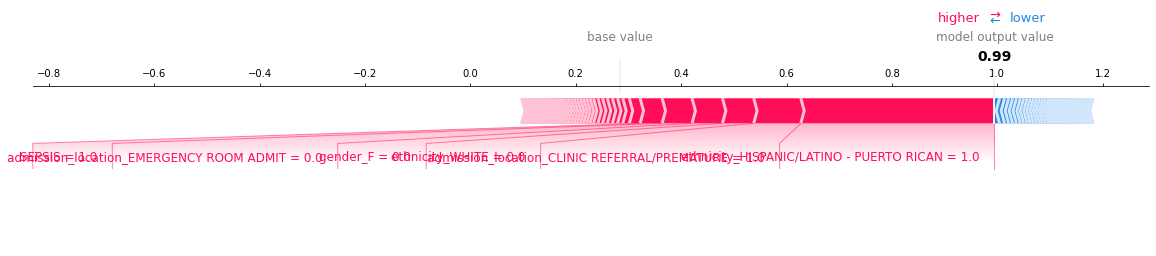

In [14]:
import shap

shap.initjs()

idx = 0
instance = test.iloc[idx,2:test.shape[1]] # shape of the instance to be explained 
class_idx = y_preds[idx].astype(int) # predicted class
feature_names = list(test.columns[2:]) 

shap.force_plot(
    shap_explainer.expected_value[class_idx],
    shap_explanation.shap_values[class_idx][idx, :],
    instance,
    feature_names = feature_names,
    matplotlib=True
)

Note that this is a local explanation. Other instances will have different weights for each feature, so we cannot generalize this output to the whole model. We can see from the plot that the ethnicity and location of admission features had the biggest influence on the model's decision to classify this instance.  We could look at other explainability methods such as [counterfactuals](https://christophm.github.io/interpretable-ml-book/counterfactual.html) to find out what changes to the input would create the correct classification. 

We see what influenced this instance the most, but what about the overall model? SHAP also offers global explanations, which can be viewed best by a `summary_plot`.

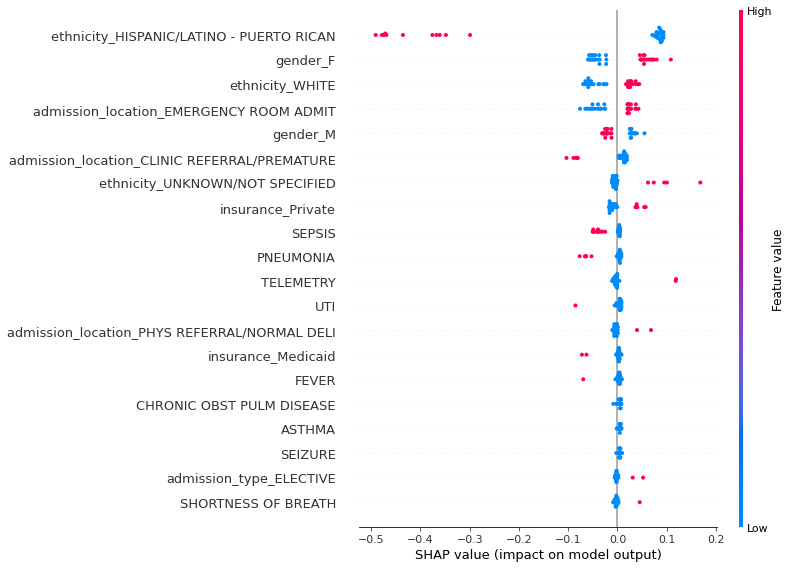

In [15]:
shap.summary_plot(shap_explanation.shap_values[idx], 
                  test.iloc[:,2:test.shape[1]],  
                  feature_names = feature_names)

This plot shows the total sum of each feature's SHAP value for each of the instances in `x_test` with a class `0` (MRSA negative). Features with the highest impact are at the top of the plot. This model has the highest valued features being `ethnicity_HISPANIC/LATINO - PUERTO RICAN`, `gender_F`, and `ethnicity_WHITE`; with the prescence of these values, the model is more likely to predict class `0`. This outcome definitely raises questions in terms of model bias or input bias: what does the underlying population look like that ethnicity and gender are driving features of this function? We would probably expect diagnoses to be more important, but it could be that there are a vast amount of diagnoses for any one to be heavily weighted. If this model was going into production, we would probably want to take a step back and do more research to ensure our model is able to generalize well to all patients.
 
# Conclusion
In the end, **explainers are not built to fix problems in models, but rather expose them.** Understanding how black-box models make decisions before launching them into production helps ensure transparency and avoid unconscious bias. 